# CS273P Final Project

### Group 13: Connor McManigal, Peyton Politewicz, Harold Hin Ng

### Import Libraries and Read in the Data

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import sklearn
from collections import Counter
import re
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob, Word, Blobber


In [3]:
df = pd.read_csv("/Users/connormcmanigal/Desktop/CS273P/Final Project/Data/Recipe Reviews and User Feedback Dataset.csv")
df = pd.DataFrame(df)

## Data Cleaning

In [4]:
# Check dataframe shape
df.shape

(18182, 15)

In [5]:
# Drop unneccessary column and check dataframe
df.drop(columns=['Unnamed: 0'], inplace = True)
df = df.dropna()
df.head()

,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,5,724,Bush used to have a white chili bean and it ma...
2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,5,710,I have a very complicated white chicken chili ...
3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,0,581,"In your introduction, you mentioned cream chee..."
4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...


In [6]:
df.shape

(18180, 14)

In [7]:
# Change unix time to date time
df['created_at'] = pd.to_datetime(df['created_at'], unit = 's')

# Check time('created_at') changes and look at unique values
df['created_at'].unique() # returns 2695 unique timestamps

<DatetimeArray>
['2022-10-13 00:11:29', '2022-10-09 01:08:07', '2022-09-28 22:35:57',
 '2022-08-29 15:43:28', '2022-10-04 20:03:43', '2022-08-24 15:19:11',
 '2022-02-05 19:20:05', '2022-02-04 02:35:14', '2022-02-04 00:05:24',
 '2022-01-26 22:57:19',
 ...
 '2022-05-09 18:14:14', '2022-04-08 07:21:21', '2022-03-21 12:27:35',
 '2022-02-11 05:02:10', '2022-02-01 04:29:27', '2022-02-23 22:41:52',
 '2021-08-08 21:44:22', '2021-06-02 15:48:18', '2021-02-11 14:06:47',
 '2021-02-11 09:45:20']
Length: 2695, dtype: datetime64[ns]

In [8]:
pol_list1 = []
pol_list2 = []
sub_list = []
sid_obj = SentimentIntensityAnalyzer()

for row in df.iloc[:, 13]: # loop through text column to calculate vader polarity, textblob polarity and subjectivity, as well as difference in polarity scores
    temp = TextBlob(row)
    sent_dict = sid_obj.polarity_scores(row)
    pol_list1.append(sent_dict['compound'])
    pol_list2.append(temp.sentiment.polarity)
    sub_list.append(temp.sentiment.subjectivity)


df = df.assign(polarity_from_vader = pol_list1) # add columns to existing df
df = df.assign(polarity_from_blob = pol_list2)

pol_list1 = np.array(pol_list1)
pol_list2 = np.array(pol_list2)
temp_diff_btw_vader_and_blob = np.subtract(pol_list1, pol_list2)
diff_btw_vader_and_blob = temp_diff_btw_vader_and_blob.tolist()
df = df.assign(diff_in_polarity_scores = diff_btw_vader_and_blob)
df = df.assign(subjectivity = sub_list)

df.head() # save as our final wrangled dataframe

,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text,polarity_from_vader,polarity_from_blob,diff_in_polarity_scores,subjectivity
0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,2022-10-13 00:11:29,0,0,0,5,527,"I tweaked it a little, removed onions because ...",0.8881,0.306481,0.581619,0.598148
1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,2022-10-09 01:08:07,0,7,0,5,724,Bush used to have a white chili bean and it ma...,0.7574,0.083333,0.674067,0.255952
2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,2022-09-28 22:35:57,0,3,0,5,710,I have a very complicated white chicken chili ...,0.9437,0.129861,0.813839,0.525000
3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,2022-08-29 15:43:28,2,2,0,0,581,"In your introduction, you mentioned cream chee...",0.0000,0.000000,0.000000,0.000000
4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,2022-10-04 20:03:43,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...,0.6114,0.233333,0.378067,0.816667


In [9]:
df.shape

(18180, 18)

## Exploratory Data Analysis

In [10]:
# Check time range of recipe reviews
min = df['created_at'].min()
max = df['created_at'].max()
print(f'Recipe reviews are from "{min}" to "{max}"')

Recipe reviews are from "2021-02-11 09:22:16" to "2022-10-14 14:00:35"


In [11]:
# Find reviews with references
reference_text = df[df['text'].str.contains('&#')]
print(f"{reference_text.shape[0]} reviews reference other previous reviews denoted with '&#'")

6336 reviews reference other previous reviews denoted with '&#'


In [12]:
# Take look at some of the reviews ('text')
df['text'].head()

0    I tweaked it a little, removed onions because ...
1    Bush used to have a white chili bean and it ma...
2    I have a very complicated white chicken chili ...
3    In your introduction, you mentioned cream chee...
4    Wonderful! I made this for a &#34;Chili/Stew&#...
Name: text, dtype: object

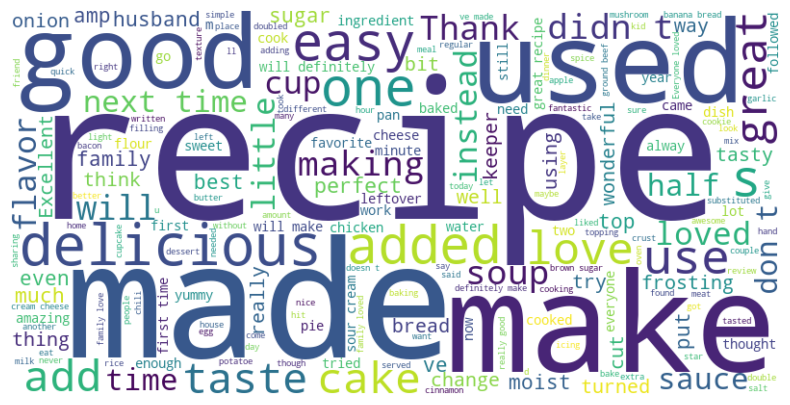

In [21]:
# Create a wordcloud from all the text
text_data = " ".join(df['text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [22]:
# Find min and max length of characters in text
min_length = np.inf
max_length = -np.inf

for text in df['text']:
    text_length = len(text)
    if text_length < min_length:
        min_length = text_length
    if text_length > max_length:
        max_length = text_length

print("Minimum length of characters:", min_length)
print("Maximum length of characters:", max_length)

Minimum length of characters: 1
Maximum length of characters: 2742


In [25]:
# Which texts have length 1?
texts_length_1 = []

for index, text in enumerate(df['text']):
    if len(text) == 1:
        texts_length_1.append((index, text))

if texts_length_1:
    print("Observations with text length of 1:")
    for index, text in texts_length_1:
        print(f"Index: {index}, Text: {text}")
else:
    print("No observations with text length of 1.")

Observations with text length of 1:
Index: 167, Text: .
Index: 252, Text: .
Index: 4282, Text: .
Index: 6014, Text: .
Index: 7556, Text: !
Index: 10048, Text:  
Index: 15047, Text:  
Index: 16062, Text: .


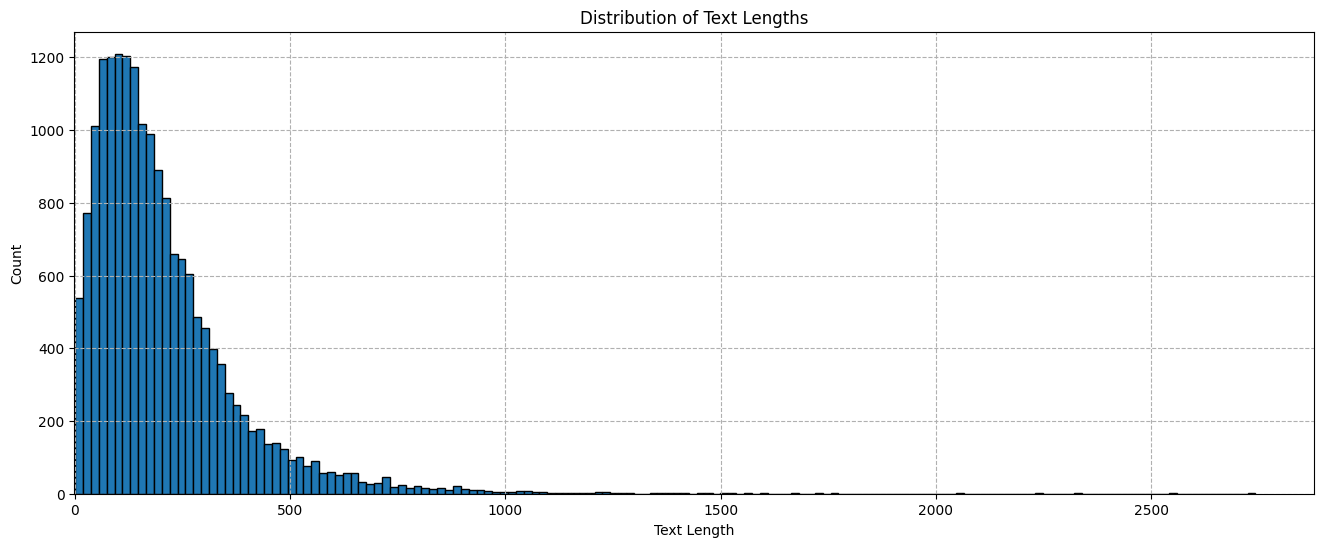

In [118]:
# Plot distribution of text lengths
text_lengths = df['text'].apply(len)

plt.figure(figsize=(16, 6))
plt.hist(text_lengths, bins=150, edgecolor = 'black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.xlim(-1)
plt.grid(True, linestyle='--', zorder=1)
plt.show()

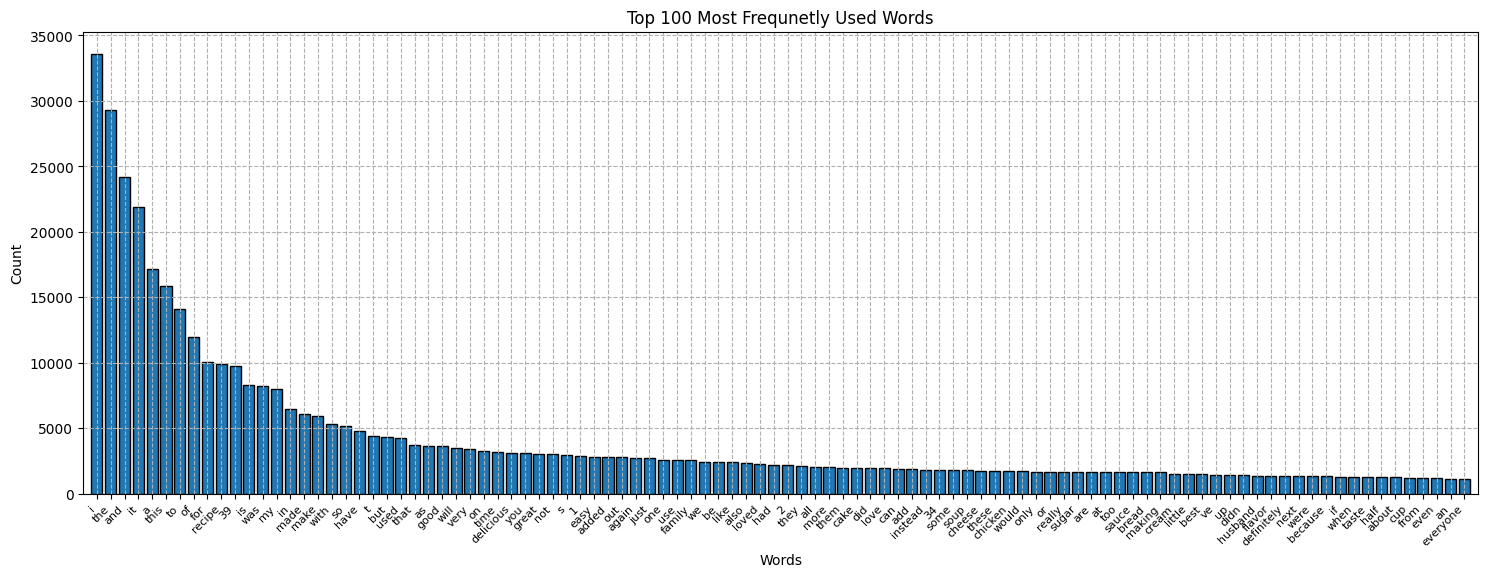

In [117]:
# Plot 100 most frequent words
all_text = ' '.join(df['text'])
words = re.findall(r'\b\w+\b', all_text.lower())

word_counts = Counter(words)
top_100_words = dict(word_counts.most_common(100))
x = np.arange(len(top_100_words))

plt.figure(figsize=(18, 6))
plt.bar(x, top_100_words.values(), edgecolor = 'black')
plt.title('Top 100 Most Frequnetly Used Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(x, top_100_words.keys(), rotation=45, ha='right', fontsize=8)
plt.xlim(-1, 100)
plt.grid(True, linestyle='--', zorder=1)
plt.show()

In [29]:
# Explore descriptive statistics of user reputations
df['user_reputation'].describe()

count    18180.000000
mean         2.159736
std         10.015210
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        520.000000
Name: user_reputation, dtype: float64

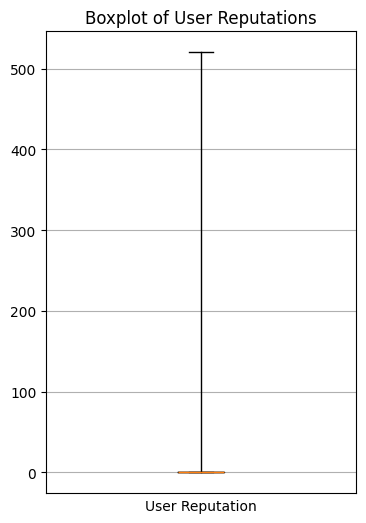

In [31]:
# Plot boxplot of user reputations
plt.figure(figsize=(4,6))
plt.boxplot(df['user_reputation'].values, whis = (0, 100))
plt.xticks([])
plt.title('Boxplot of User Reputations')
plt.xlabel('User Reputation')
plt.grid(True)
plt.show() # Plot shows reputations are heavily skewed toward 1 with very large outliers(520) -> perhaps suggests a UR of 1 is default

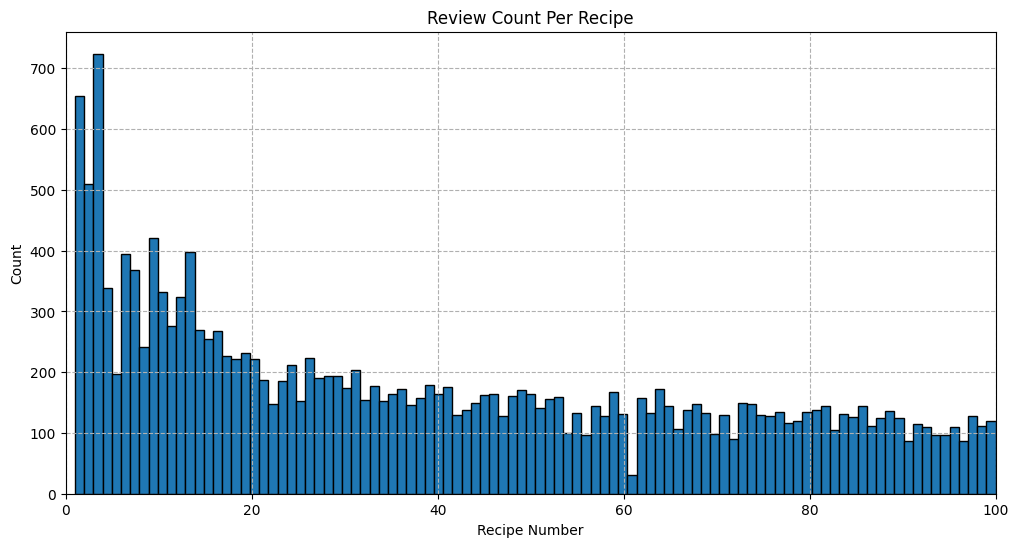

In [32]:
# Plot counts of number of reviews per recipe
plt.figure(figsize = (12,6))
plt.hist(df['recipe_number'], bins = 100, edgecolor = 'black')
plt.title('Review Count Per Recipe')
plt.xlabel('Recipe Number')
plt.ylabel('Count')
plt.xlim(0,100)
plt.grid(True, linestyle='--', zorder=0)
plt.show()

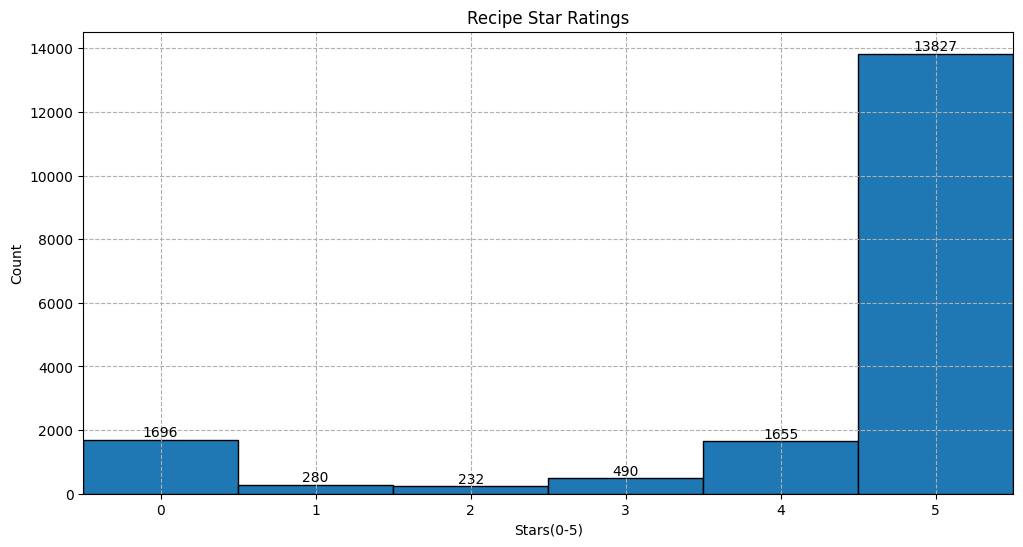

In [33]:
# Check distribution of recipe star ratings
bin_edges = np.arange(-0.5, 6.5, 1)

plt.figure(figsize=(12,6))
counts, bins, _ = plt.hist(df['stars'], bins = bin_edges, edgecolor = 'black', zorder=0)

# Add annotations at the top of each bin
for count, bin_edge in zip(counts, bins[:-1]):
    plt.text(bin_edge + 0.5, count, str(int(count)), ha='center', va='bottom')

plt.title('Recipe Star Ratings')
plt.xlabel('Stars(0-5)')
plt.ylabel('Count')
plt.xlim(-0.5,5.5)
plt.grid(True, linestyle='--', zorder=1)
plt.show()

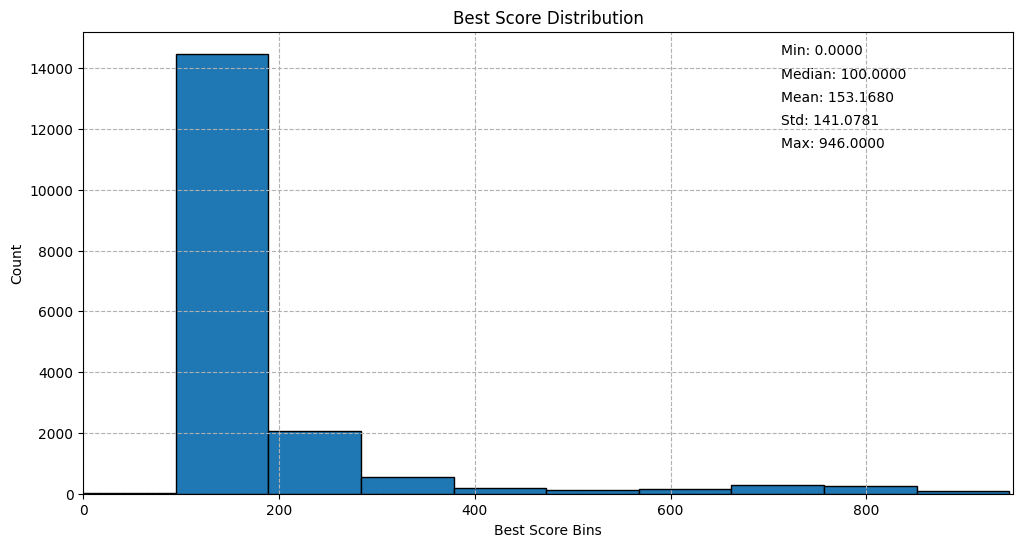

In [116]:
# Plot counts of number of reviews per recipe
plt.figure(figsize = (12,6))
plt.hist(df['best_score'], bins = 10, edgecolor = 'black')
plt.title('Best Score Distribution')
plt.xlabel('Best Score Bins')
plt.ylabel('Count')
plt.xlim(0,950)
plt.grid(True, linestyle='--', zorder=0)

stats = {
    'Min': np.min(df['best_score']),
    'Median': np.percentile(df['best_score'], 50),
    'Mean': np.mean(df['best_score']),
    'Std': np.std(df['best_score']),
    'Max': np.max(df['best_score'])
}

for i, (key, value) in enumerate(stats.items()):
    plt.text(0.75, 0.95 - i * 0.05, f"{key}: {value:.4f}", transform=plt.gca().transAxes)

plt.show()

#### Explore Sentiment Results

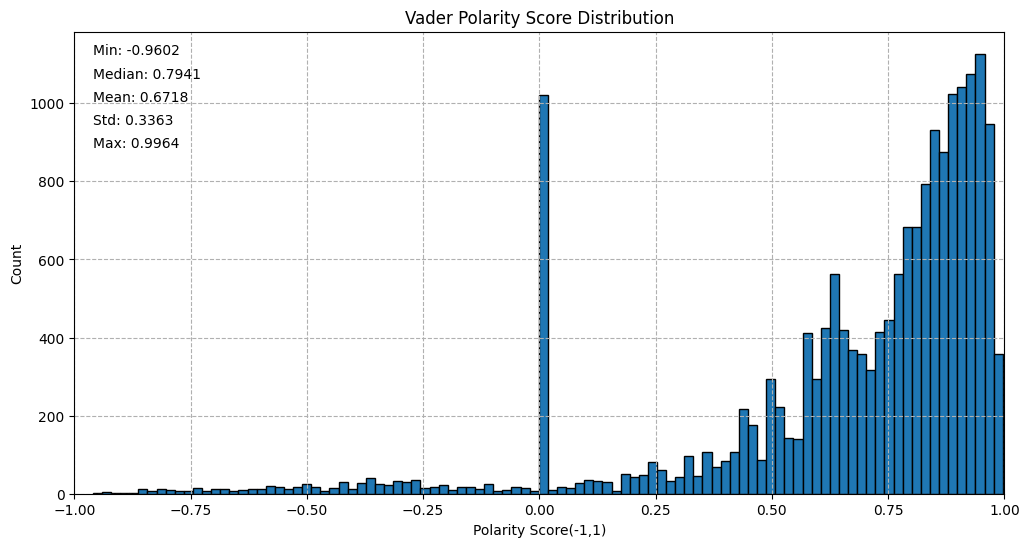

In [76]:
# Plot vader polarity distribution
plt.figure(figsize = (12,6))
plt.hist(df['polarity_from_vader'], bins = 100, edgecolor = 'black')
plt.title('Vader Polarity Score Distribution')
plt.xlabel('Polarity Score(-1,1)')
plt.ylabel('Count')
plt.xlim(-1,1)
plt.grid(True, linestyle='--', zorder=0)

stats = {
    'Min': np.min(df['polarity_from_vader']),
    'Median': np.percentile(df['polarity_from_vader'], 50),
    'Mean': np.mean(df['polarity_from_vader']),
    'Std': np.std(df['polarity_from_vader']),
    'Max': np.max(df['polarity_from_vader'])
}

for i, (key, value) in enumerate(stats.items()):
    plt.text(0.02, 0.95 - i * 0.05, f"{key}: {value:.4f}", transform=plt.gca().transAxes)

plt.show()

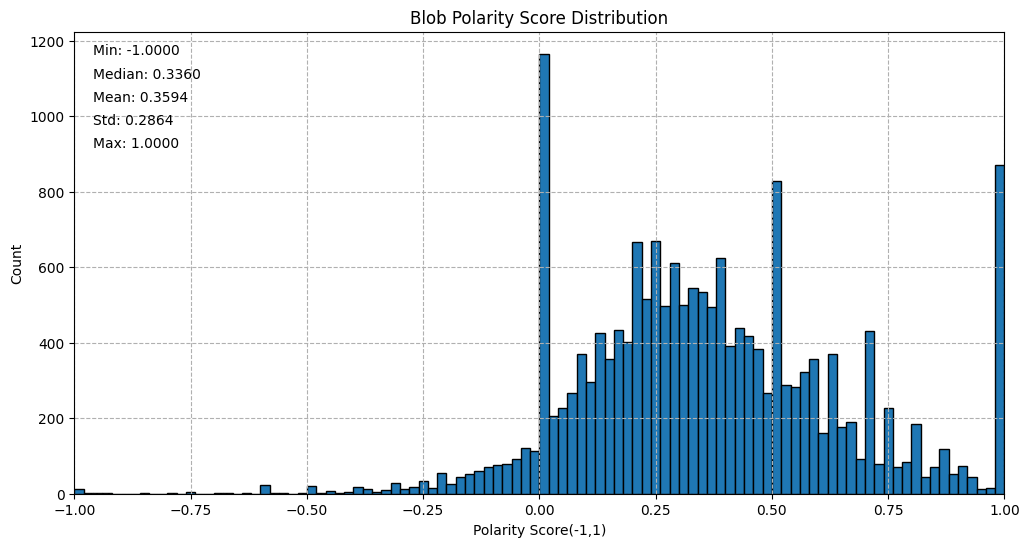

In [79]:
# Plot blob polarity distribution
plt.figure(figsize = (12,6))
plt.hist(df['polarity_from_blob'], bins = 100, edgecolor = 'black')
plt.title('Blob Polarity Score Distribution')
plt.xlabel('Polarity Score(-1,1)')
plt.ylabel('Count')
plt.xlim(-1,1)
plt.grid(True, linestyle='--', zorder=0)

stats = {
    'Min': np.min(df['polarity_from_blob']),
    'Median': np.percentile(df['polarity_from_blob'], 50),
    'Mean': np.mean(df['polarity_from_blob']),
    'Std': np.std(df['polarity_from_blob']),
    'Max': np.max(df['polarity_from_blob'])
}

for i, (key, value) in enumerate(stats.items()):
    plt.text(0.02, 0.95 - i * 0.05, f"{key}: {value:.4f}", transform=plt.gca().transAxes)

plt.show()

In [80]:
positive_polarity_vader = df[df['polarity_from_vader'] > 0.2]
positive_polarity_blob = df[df['polarity_from_blob'] > 0.2]

print('Vader Positive polarity observations: ', positive_polarity_vader.shape[0])
print('Blob Positive polarity observations: ', positive_polarity_blob.shape[0])

Vader Positive polarity observations:  16201
Blob Positive polarity observations:  12797


In [81]:
neutral_polarity_vader = df[(df['polarity_from_vader'] >= -0.2) & (df['polarity_from_vader'] <= 0.2)]
neutral_polarity_blob = df[(df['polarity_from_blob'] >= -0.2) & (df['polarity_from_blob'] <= 0.2)]


print('Vader Neutral polarity observations: ', neutral_polarity_vader.shape[0])
print('Blob Neutral polarity observations: ', neutral_polarity_blob.shape[0])

Vader Neutral polarity observations:  1388
Blob Neutral polarity observations:  5109


In [82]:
negative_polarity_vader = df[df['polarity_from_vader'] < -0.2]
negative_polarity_blob = df[df['polarity_from_blob'] < -0.2]

print('Vader Negative polarity observations: ', negative_polarity_vader.shape[0])
print('Blob Negative polarity observations: ', negative_polarity_blob.shape[0])

Vader Negative polarity observations:  591
Blob Negative polarity observations:  274


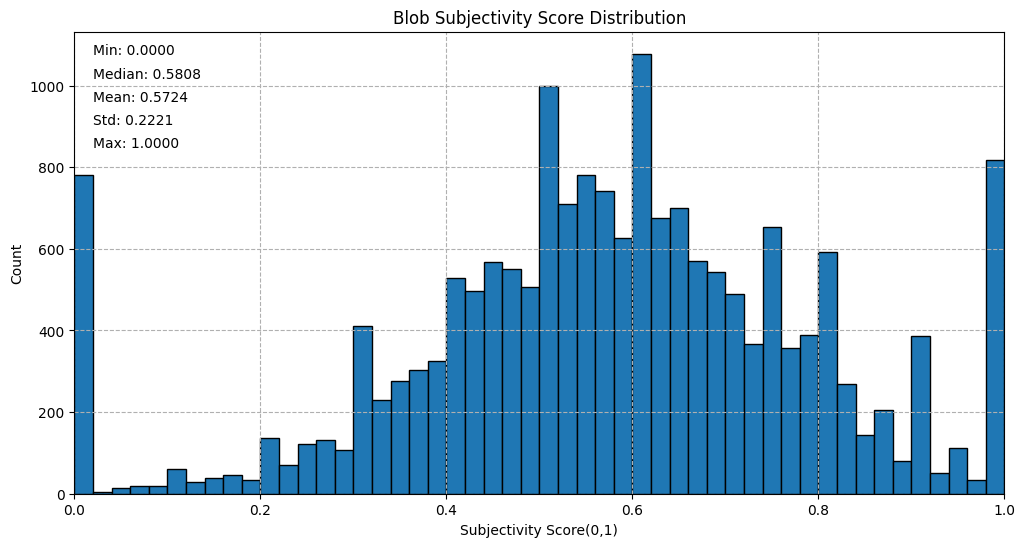

In [83]:
# Take a look at subjectivity from blob
plt.figure(figsize = (12,6))
plt.hist(df['subjectivity'], bins = 50, edgecolor = 'black')
plt.title('Blob Subjectivity Score Distribution')
plt.xlabel('Subjectivity Score(0,1)')
plt.ylabel('Count')
plt.xlim(0,1)
plt.grid(True, linestyle='--', zorder=0)

stats = {
    'Min': np.min(df['subjectivity']),
    'Median': np.percentile(df['subjectivity'], 50),
    'Mean': np.mean(df['subjectivity']),
    'Std': np.std(df['subjectivity']),
    'Max': np.max(df['subjectivity'])
}

for i, (key, value) in enumerate(stats.items()):
    plt.text(0.02, 0.95 - i * 0.05, f"{key}: {value:.4f}", transform=plt.gca().transAxes)

plt.show()


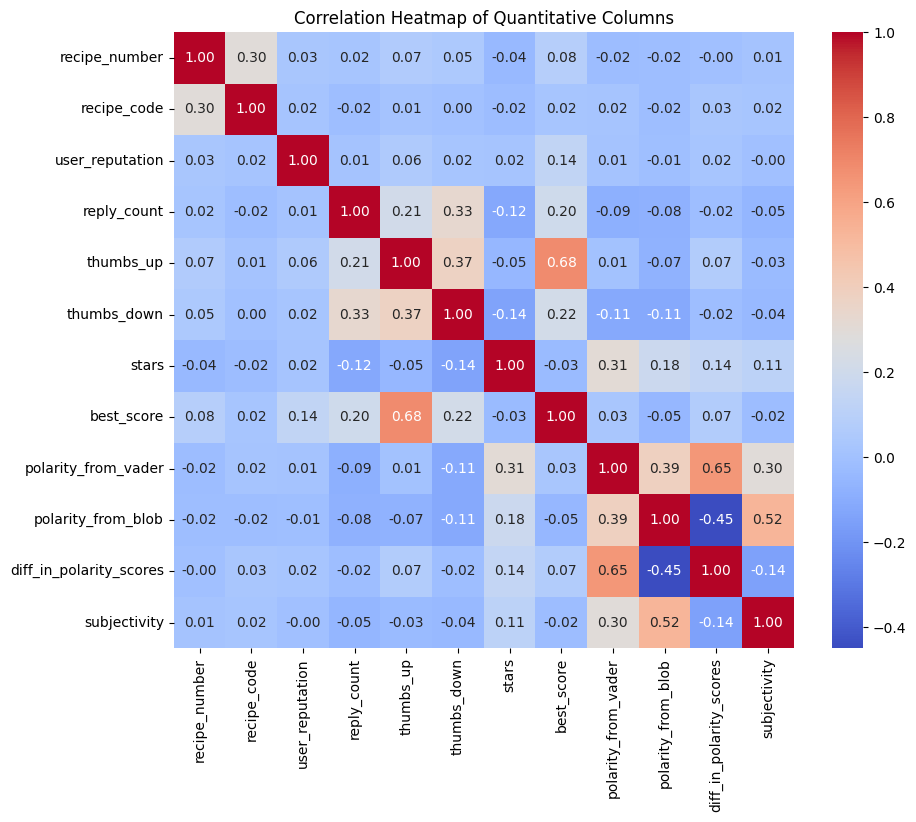

In [98]:
# Plot heatmap of quantitative columns
quant_df = df.select_dtypes(include=['int', 'float'])

plt.figure(figsize=(10, 8))
sns.heatmap(quant_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Quantitative Columns')
plt.show()

## Stratification

## Predicting best_score